 # Fruit Ripeness Detection 

### Importing required libraries

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, MaxPool2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Model
import os
import matplotlib.pyplot as plt
import glob
import cv2
import seaborn as sns
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [24]:
TRAIN_PATH = 'D:/IIT/Data Science Group Project/Notebook/Multi-modal-Fruit-Ripeness-Detection-System/FruitModel/Dataset/train'
VAL_PATH = 'D:/IIT/Data Science Group Project/Notebook/Multi-modal-Fruit-Ripeness-Detection-System/FruitModel/Dataset/val'
TEST_PATH = 'D:/IIT/Data Science Group Project/Notebook/Multi-modal-Fruit-Ripeness-Detection-System/FruitModel/Dataset/test'

### Initializing Image Size

In [25]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

### Initializing train, validation & test data

In [26]:
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                  zoom_range=0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(TRAIN_PATH,
                                                   target_size=(IMAGE_SIZE),
                                                   batch_size=BATCH_SIZE,
                                                   class_mode='categorical',
                                                   shuffle=True)

Found 4840 images belonging to 3 classes.


In [27]:
validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_directory(VAL_PATH,
                                                             target_size=(IMAGE_SIZE),
                                                             batch_size=BATCH_SIZE,
                                                             class_mode='categorical',
                                                             shuffle=True)

Found 660 images belonging to 3 classes.


In [28]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : Over Ripe
1 : Ripe
2 : Unripe


### Plot Images with labels

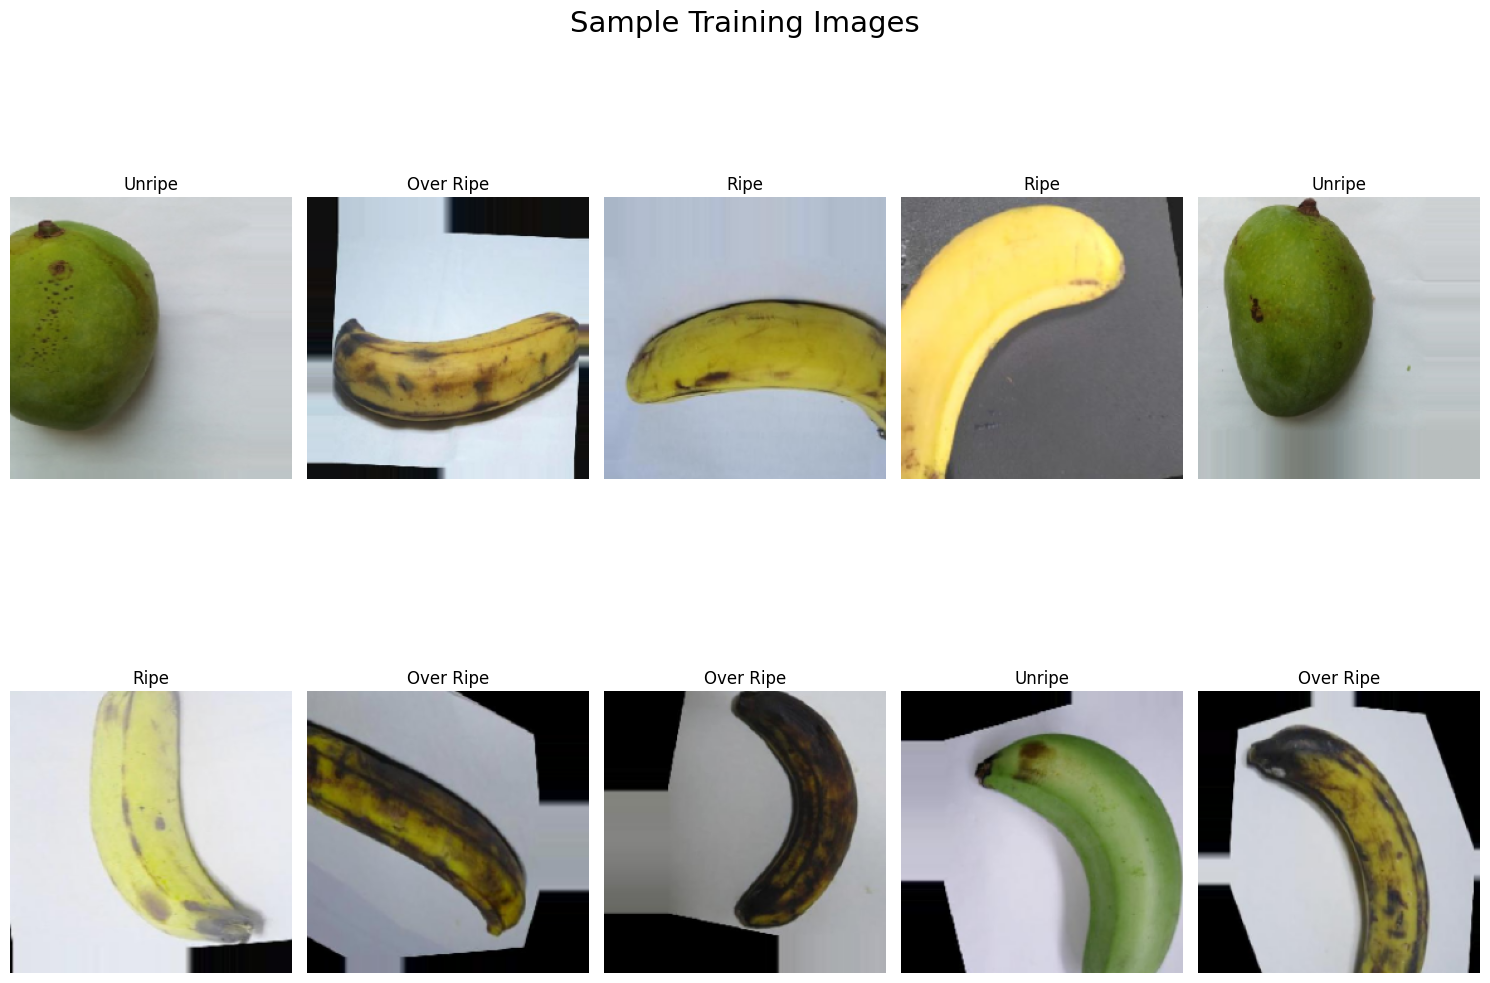

In [29]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 12))
idx = 0

for i in range(2):
    for j in range(5):
        label = labels[np.argmax(train_generator[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()

In [30]:
class_num = 3
image_w = 224
image_h = 224

### Import model for Transfer Learning

In [31]:
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16

inputs = layers.Input(shape=(image_w,image_h, 3))

outputs = VGG16(include_top=True, weights=None, classes=class_num)(inputs)

In [33]:
# model = tf.keras.Model(inputs, outputs)

# model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"] )

# Define your model architecture
model = tf.keras.Model(inputs, outputs)

# Compile the model using the Adam optimizer from tf.keras.optimizers
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss="categorical_crossentropy", 
              metrics=["accuracy"])


In [34]:
model.summary() 

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 3)              │   134,272,835 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,272,835 (512.21 MB)

 Trainable params: 134,272,835 (512.21 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
def learning_rate_schedule(epoch, lr):
    if epoch < 3:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_scheduler = LearningRateScheduler(learning_rate_schedule)

In [36]:
early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=5,          
    restore_best_weights=True, 
)

### Train the model

In [37]:
hist = model.fit(train_generator, validation_data = validation_generator, epochs=50, verbose=2, callbacks = [lr_scheduler,early_stopping])

Epoch 1/50


c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


152/152 - 900s - 6s/step - accuracy: 0.3579 - loss: 1.1243 - val_accuracy: 0.3333 - val_loss: 1.1017 - learning_rate: 0.0010
Epoch 2/50


KeyboardInterrupt: 

### Train, Validation & Test accuracy from saved model

In [ ]:
train_accuracy = hist.history['accuracy']
val_accuracy = hist.history['val_accuracy']

train_loss = hist.history['loss']
val_loss = hist.history['val_loss']

learning_rate = hist.history['lr']



### Plot Accuracy & Loss graphs

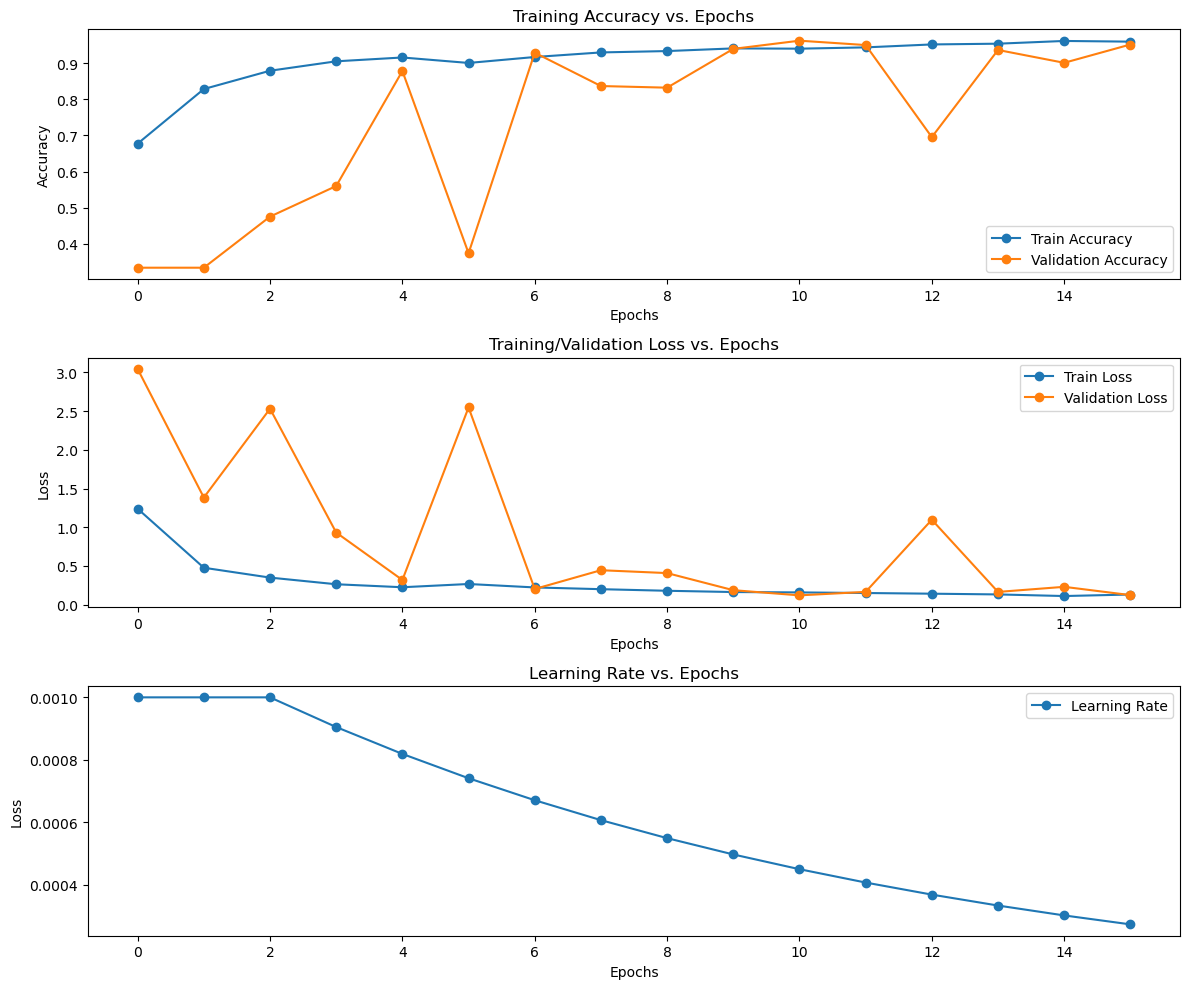

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

ax[2].set_title('Learning Rate vs. Epochs')
ax[2].plot(learning_rate, 'o-', label='Learning Rate')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Loss')
ax[2].legend(loc='best')

plt.tight_layout()
plt.show()

### Predictions on Test data

In [ ]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(TEST_PATH,
                                                 shuffle=False,
                                                 batch_size=BATCH_SIZE,
                                                 target_size = (IMAGE_SIZE),
                                                 class_mode='categorical')


Found 660 images belonging to 3 classes.


In [ ]:


predictions = model.predict(test_generator)

21/21 [==============================] - 5s 187ms/step


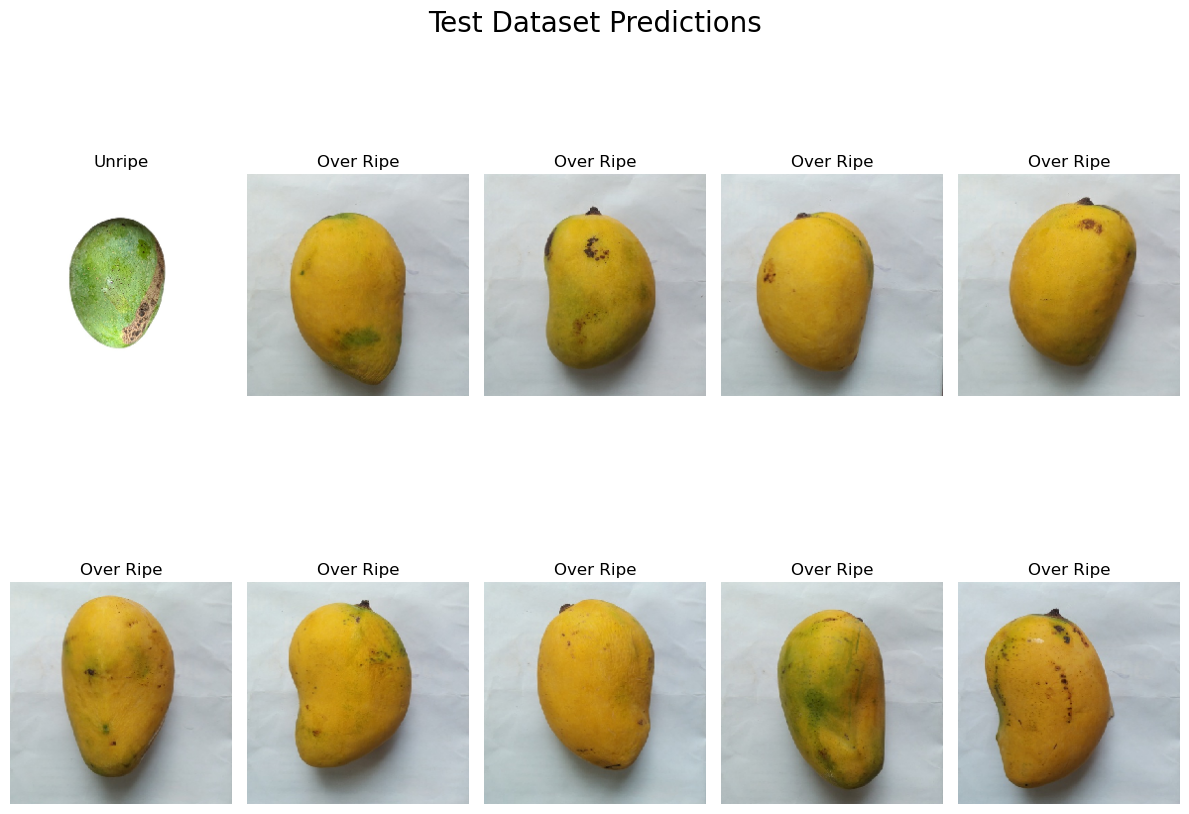

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        predicted_label = labels[np.argmax(predictions[idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(test_generator[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()

### F1- Score, Precision & Recall

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator, batch_size=BATCH_SIZE)

21/21 [==============================] - 4s 158ms/step - loss: 0.1333 - accuracy: 0.9561


### Confusion Matrix

In [ ]:
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss:     0.13325731456279755
Test Accuracy: 0.9560605883598328


In [ ]:
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

[[198  21   1]
 [  3 215   2]
 [  1   1 218]]


<Axes: >

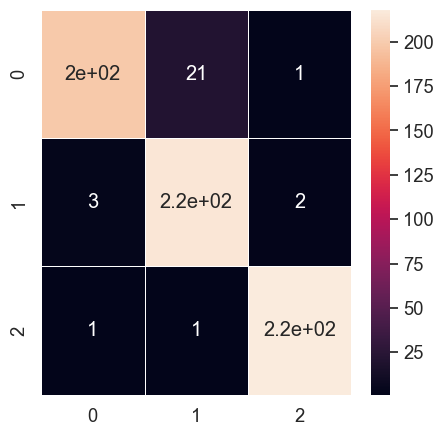

In [ ]:
cm = confusion_matrix(y_true, y_pred)
print(cm)
fig, ax = plt.subplots(figsize=(5,5))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_true, y_pred, target_names=labels.values()))

              precision    recall  f1-score   support

   Over Ripe       0.98      0.90      0.94       220
        Ripe       0.91      0.98      0.94       220
      Unripe       0.99      0.99      0.99       220

    accuracy                           0.96       660
   macro avg       0.96      0.96      0.96       660
weighted avg       0.96      0.96      0.96       660



In [ ]:
errors = (y_true - y_pred != 0)
y_true_errors = y_true[errors]
y_pred_errors = y_pred[errors]

In [ ]:
test_images = test_generator.filenames
test_img = np.asarray(test_images)[errors]

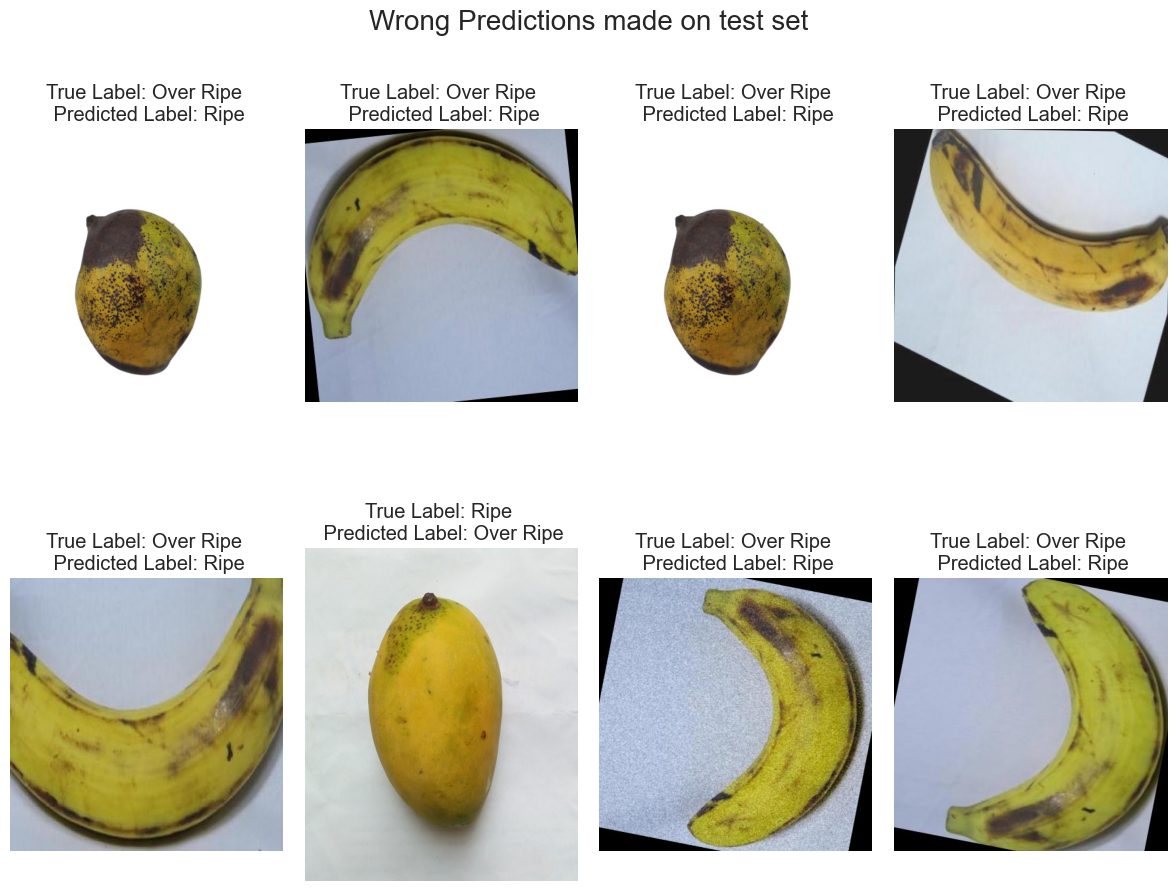

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(4):
        idx = np.random.randint(0, len(test_img))
        true_index = y_true_errors[idx]
        true_label = labels[true_index]
        predicted_index = y_pred_errors[idx]
        predicted_label = labels[predicted_index]
        ax[i, j].set_title(f"True Label: {true_label} \n Predicted Label: {predicted_label}")
        img_path = os.path.join(TEST_PATH, test_img[idx])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax[i, j].imshow(img)
        ax[i, j].axis("off")

plt.tight_layout()
plt.suptitle('Wrong Predictions made on test set', fontsize=20)
plt.show()

In [ ]:
tf.keras.models.save_model(model, "/content/Mydrive/MyDrive/VGG16.keras")